In [1]:
%%time
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# 데이터 로딩 및 전처리
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

CPU times: user 2.98 s, sys: 1.34 s, total: 4.32 s
Wall time: 3.69 s


In [2]:
%%time
# BasicBlock 정의
def BasicBlock(inputs, filters, stride=1):
    shortcut = inputs

    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# ResNet 정의
def ResNet18():
    inputs = Input(shape=(32, 32, 3))

    x = Conv2D(64, (3, 3), strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = BasicBlock(x, 64)
    x = BasicBlock(x, 64)
    x = BasicBlock(x, 128, stride=2)
    x = BasicBlock(x, 128)
    x = BasicBlock(x, 256, stride=2)
    x = BasicBlock(x, 256)
    x = BasicBlock(x, 512, stride=2)
    x = BasicBlock(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [3]:
%%time
model = ResNet18()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [4]:
%%time
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

CPU times: user 9.18 ms, sys: 1.51 ms, total: 10.7 ms
Wall time: 8.87 ms


In [5]:
%%time
# 학습 루프 batch_size = 128 로 오리지널에 비해 4배 증가, 에폭 50회 진행
history = model.fit(x_train, y_train, batch_size=128, epochs=50)
test_loss, test_acc = model.evaluate(x_test, y_test)

# 모델 평가
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Epoch 1/50
391/391 [==============================] - 49s 111ms/step - loss: 1.2712 - accuracy: 0.5429
Epoch 2/50
391/391 [==============================] - 44s 112ms/step - loss: 0.7551 - accuracy: 0.7330
Epoch 3/50
391/391 [==============================] - 44s 111ms/step - loss: 0.5470 - accuracy: 0.8104
Epoch 4/50
391/391 [==============================] - 44s 112ms/step - loss: 0.4252 - accuracy: 0.8519
Epoch 5/50
391/391 [==============================] - 44s 112ms/step - loss: 0.3208 - accuracy: 0.8865
Epoch 6/50
391/391 [==============================] - 44s 111ms/step - loss: 0.2415 - accuracy: 0.9152
Epoch 7/50
391/391 [==============================] - 44s 112ms/step - loss: 0.1827 - accuracy: 0.9371
Epoch 8/50
391/391 [==============================] - 44s 112ms/step - loss: 0.1286 - accuracy: 0.9541
Epoch 9/50
391/391 [==============================] - 44s 112ms/step - loss: 0.1031 - accuracy: 0.9639
Epoch 10/50
391/391 [==============================] - 44s 111ms/step - l

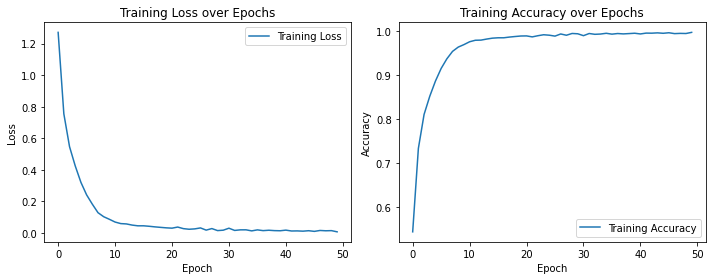

CPU times: user 375 ms, sys: 237 ms, total: 611 ms
Wall time: 282 ms


In [6]:
%%time
# 학습 결과 시각화
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# batch_size = 128로 증가 & 에폭 50회 실행
# 에폭 50회 연산 시간 : 36 : 34
# Train acc : 0.99
# Test acc : 0.83
# Test loss : 1.0809

# Test02과 비교 (Test02 에폭 100회 연산 시간 : 1: 16 : 19)
# 에폭 50회 연산을 초로 환산 : (36* 60) + 34 = 2,194
# 환산된 값에 10/5을 곱셈 : 2,194 / 5 * 10 = 4,388
# 4,388 / 60 = 73.13 = 약 1시간 13 분 8초

# 배치 증가로 에폭당 평균속도는 6초씩 줄어 들은것으로 관찰되나, 파이프라인 작업으로는 약 3분 정도 감소한 것으로 추정

In [ ]:
# 피드백 및 느낀점

# 1) 파이프라인 작업으로는 유의미한 속도를 내는 점은 없으나,
# 배치사이즈를 늘리는 것은 큰 의미가 있는 것으로 관찰되는 것을 확인

# 2) 파이프라인 작업에서의 유의미한 성과를 얻으려면 어떤 조건이어야 하는지, 또는 어떻게 코드 구현해야 하는지 더 알아봐야 할 것 같다.

# 3) 평소에는 에폭을 10~ 20정도로 하다 100회씩 하니 연산 속도가 줄어드는 것에 대한 편의성이 와닿았고
# 배치 사이즈를 늘리면 연산 속도가 증가한다는 점을 제대로 느꼈던 것 같다.